## Imports and reading dataset


!pip install transformers torch

!pip install seqeval

!pip install git+https://www.github.com/keras-team/keras-contrib.git

!pip install googletrans==4.0.0-rc1
!pip install --upgrade googletrans==4.0.0-rc1
!pip install imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
import nltk
nltk.download('punkt')
import torch
from transformers import AutoTokenizer, AutoModel
import pickle
from imblearn.over_sampling import SMOTE
# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
# keras
from keras.models import Sequential, load_model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\husse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df = pd.read_csv("datasets\HussFranco.csv")
df = df.sort_values(by='emotion').reset_index(drop=True)
df

,text,emotion
0,y3ny atfal2 wnta,anger
1,ana mt3sab gdan 3alafekra,anger
2,eh el araf da,anger
3,ana bakrahak awii,anger
4,w7sh awii,anger
...,...,...
951,ana mtfag2 men el tweet de awii,surprise
952,keda kont amar?,surprise
953,anti lesa mawgoda ana kont fakrak mshet,surprise
954,ana monbaher men 7aga zay kda,surprise


- Trim Dataset to a Maximum of 100 Samples per Class

none: Count = 374 -----------------> Percentage = 39.12%
happiness: Count = 192 -----------------> Percentage = 20.08%
anger: Count = 135 -----------------> Percentage = 14.12%
surprise: Count = 100 -----------------> Percentage = 10.46%
sadness: Count = 90 -----------------> Percentage = 9.41%
fear: Count = 65 -----------------> Percentage = 6.80%


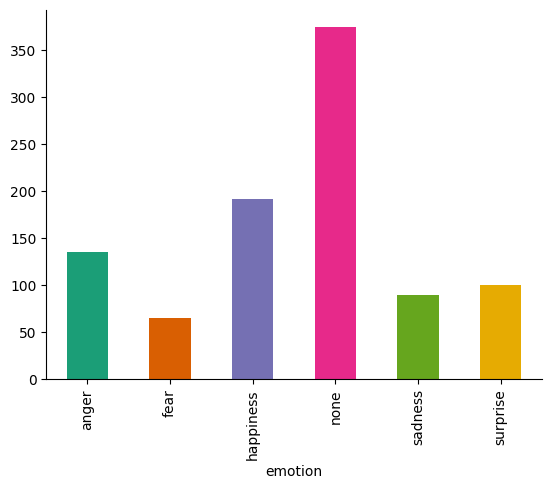

In [8]:
df.groupby('emotion').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

# Calculating and printing percentages in descending order
emotion_counts = df['emotion'].value_counts()
total_samples = len(df)

for emotion, count in emotion_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{emotion}: Count = {count} -----------------> Percentage = {percentage:.2f}%")

## a) Step 1 : Preprocessing

+ Remove URLs
+ Remove user mentions
+ Remove hashtags
+ Remove punctuation
+ Tokenize the text
+ Convert to lower case
+ Join the tokens back into a clean text

<!-- + Remove repeated letters -->




In [11]:
def clean_text(text):
    # Remove URLs https://www.example.com/
    text = re.sub(r'http\S+', '', text)
    # Remove user mentions @mohamed_samy
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags #free_palestine
    text = re.sub(r'#', '', text)
    # Remove punctuation period, comma, apostrophe, quotation, question, exclamation, brackets, braces, parenthesis, dash, hyphen, ellipsis, colon, semicolon
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove repeated letters
    # tokens = [re.sub(r'(.)\1+', r'\1', word) for word in tokens]
    # Convert to lower case
    tokens = [word.lower() for word in tokens]
    # Join the tokens back into a clean text
    clean_text = ' '.join(tokens)
    return clean_text

df['clean_text'] = df['text'].apply(clean_text)
df

C:\Users\husse\AppData\Local\Temp\ipykernel_7784\830834750.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(clean_text)


,text,emotion,clean_text
0,y3ny atfal2 wnta,anger,y3ny atfal2 wnta
1,ana mt3sab gdan 3alafekra,anger,ana mt3sab gdan 3alafekra
2,eh el araf da,anger,eh el araf da
3,ana bakrahak awii,anger,ana bakrahak awii
4,w7sh awii,anger,w7sh awii
...,...,...,...
951,ana mtfag2 men el tweet de awii,surprise,ana mtfag2 men el tweet de awii
952,keda kont amar?,surprise,keda kont amar
953,anti lesa mawgoda ana kont fakrak mshet,surprise,anti lesa mawgoda ana kont fakrak mshet
954,ana monbaher men 7aga zay kda,surprise,ana monbaher men 7aga zay kda


- Removing Duplicates again after cleaning

In [9]:
df = df.drop_duplicates()
df.shape

(944, 2)

In [30]:
test_clean = clean_text("@Mo_Hussein eh elgamal da 1000 mabrook 3o2bal AMR!!")
test_clean

'eh elgamal da 1000 mabrook 3o2bal amr'

### Translate clean_text to Arabic


https://github.com/ssut/py-googletrans/issues/257

In [19]:
from googletrans import Translator

def translate_to_arabic(text):
    translator = Translator()
    translation = translator.translate(text, dest='ar')
    return translation.text

In [32]:
test_statment = translate_to_arabic("eh elgamal da 1000 mabrook 3o2bal amr")
print(test_statment)

إيه الجمال دى ١٠٠٠ مبروك عقبال أمر


In [33]:
df['arabic_text'] = df['clean_text'].apply(translate_to_arabic)
df

C:\Users\husse\AppData\Local\Temp\ipykernel_7784\2469135682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arabic_text'] = df['clean_text'].apply(translate_to_arabic)


,text,emotion,clean_text,arabic_text
0,y3ny atfal2 wnta,anger,y3ny atfal2 wnta,يعني أطفالا ونتا
1,ana mt3sab gdan 3alafekra,anger,ana mt3sab gdan 3alafekra,أنا متعصب جدا عالفكرة
2,eh el araf da,anger,eh el araf da,إيه إل عرف دى
3,ana bakrahak awii,anger,ana bakrahak awii,أنا بكرهك أوي
4,w7sh awii,anger,w7sh awii,وحش أوي
...,...,...,...,...
951,ana mtfag2 men el tweet de awii,surprise,ana mtfag2 men el tweet de awii,أنا متفاجئ من إل طويت د أوي
952,keda kont amar?,surprise,keda kont amar,اي واحدة ملكي؟
953,anti lesa mawgoda ana kont fakrak mshet,surprise,anti lesa mawgoda ana kont fakrak mshet,أنتي لسة موجودة أنا كنت فكرك مشت
954,ana monbaher men 7aga zay kda,surprise,ana monbaher men 7aga zay kda,أنا منبهر من حاجة زي كدة


## b) Step 2: The usage of Word Embedding
+ AraBERT


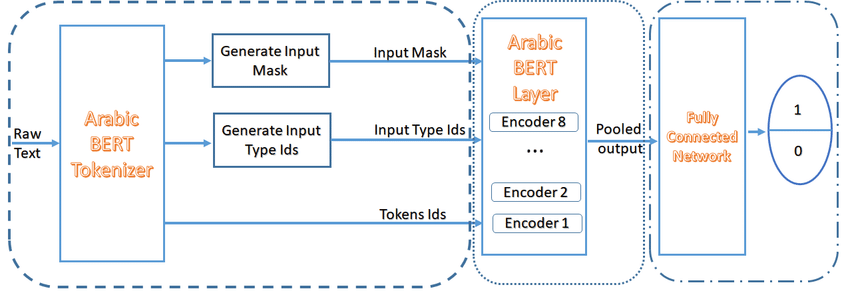

https://huggingface.co/asafaya/bert-base-arabic

- Load the pre-trained AraBERT tokenizer and model

In [34]:
AraBERT_tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
AraBERT_model = AutoModel.from_pretrained("asafaya/bert-base-arabic")

def get_embeddings(text):
    tokens = AraBERT_tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = AraBERT_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

In [35]:
df['arabert_embeddings'] = df['arabic_text'].apply(get_embeddings)
df

C:\Users\husse\AppData\Local\Temp\ipykernel_7784\3845998709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arabert_embeddings'] = df['arabic_text'].apply(get_embeddings)


,text,emotion,clean_text,arabic_text,arabert_embeddings
0,y3ny atfal2 wnta,anger,y3ny atfal2 wnta,يعني أطفالا ونتا,"[-0.08232402, -0.664338, -0.63913244, -0.12390..."
1,ana mt3sab gdan 3alafekra,anger,ana mt3sab gdan 3alafekra,أنا متعصب جدا عالفكرة,"[-0.08633613, -0.22322781, -0.49166924, 0.0399..."
2,eh el araf da,anger,eh el araf da,إيه إل عرف دى,"[-0.06145324, -1.5116544, -0.06539703, -0.0874..."
3,ana bakrahak awii,anger,ana bakrahak awii,أنا بكرهك أوي,"[-0.04267763, -0.3388501, -0.08202514, 0.10948..."
4,w7sh awii,anger,w7sh awii,وحش أوي,"[0.19331887, -0.3863656, -0.31878814, 0.162612..."
...,...,...,...,...,...
951,ana mtfag2 men el tweet de awii,surprise,ana mtfag2 men el tweet de awii,أنا متفاجئ من إل طويت د أوي,"[0.053882077, -0.4873544, -0.12486834, -0.2368..."
952,keda kont amar?,surprise,keda kont amar,اي واحدة ملكي؟,"[0.1487812, -0.61953086, -0.52761793, 0.129423..."
953,anti lesa mawgoda ana kont fakrak mshet,surprise,anti lesa mawgoda ana kont fakrak mshet,أنتي لسة موجودة أنا كنت فكرك مشت,"[-0.032839525, -0.859931, -0.50123745, -0.3032..."
954,ana monbaher men 7aga zay kda,surprise,ana monbaher men 7aga zay kda,أنا منبهر من حاجة زي كدة,"[0.0027400197, -0.3430679, -0.30084923, -0.194..."


- Save the dataset after embedding

In [36]:
# after_embedding_df = df.copy()
# after_embedding_df.to_csv('after_embedding_df.csv', index=False)

## c) Step 3: Models Development
+ Split data into 80% train and 20% test
+ Bi-LSTM model devalopment
+ CNN model devalopment

https://en.wikipedia.org/wiki/Conditional_random_field#:~:text=Conditional%20random%20fields%20(CRFs)%20are,can%20take%20context%20into%20account.

In [37]:
X = df['arabert_embeddings'].astype(str).tolist()
y = df['emotion']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

X_padded = pad_sequences(X_sequences)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


Bi-LSTM


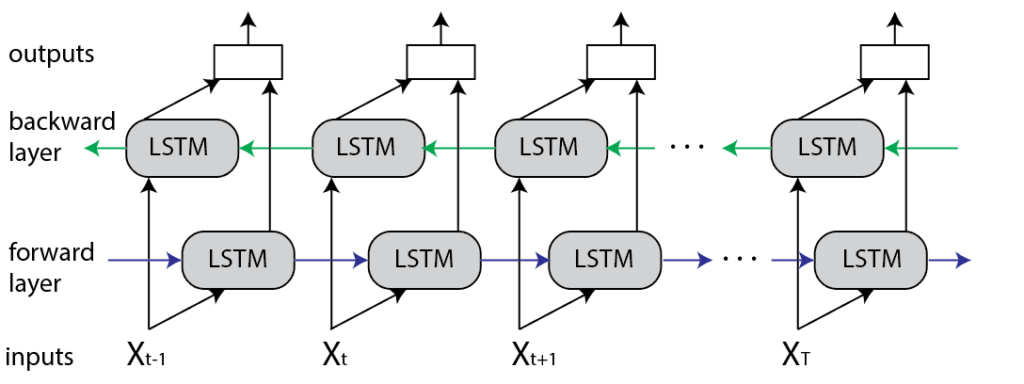

In [38]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
model_lstm.add(Bidirectional(LSTM(64,return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(32)))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(7, activation='softmax'))

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)

print(f"LSTM Model Accuracy: {accuracy_lstm * 100}%")



Epoch 1/10


22/22 [==============================] - 69s 3s/step - loss: 1.7501 - accuracy: 0.3800 - val_loss: 1.6023 - val_accuracy: 0.3947
Epoch 2/10
22/22 [==============================] - 55s 2s/step - loss: 1.6303 - accuracy: 0.3918 - val_loss: 1.6037 - val_accuracy: 0.3947
Epoch 3/10
22/22 [==============================] - 59s 3s/step - loss: 1.5946 - accuracy: 0.3918 - val_loss: 1.6045 - val_accuracy: 0.3947
Epoch 4/10
22/22 [==============================] - 61s 3s/step - loss: 1.4448 - accuracy: 0.4448 - val_loss: 1.8190 - val_accuracy: 0.3947
Epoch 5/10
22/22 [==============================] - 55s 2s/step - loss: 0.9915 - accuracy: 0.6451 - val_loss: 2.1566 - val_accuracy: 0.2105
Epoch 6/10
22/22 [==============================] - 67s 3s/step - loss: 0.6284 - accuracy: 0.7393 - val_loss: 2.6777 - val_accuracy: 0.2237
Epoch 7/10
22/22 [==============================] - 63s 3s/step - loss: 0.4175 - accuracy: 0.8336 - val_loss: 3.0522 - val_accuracy: 0.1842
Epoch 8/10
22/22

In [39]:
class_names = label_encoder.classes_
y_test_names = label_encoder.inverse_transform(y_test)
y_pred_names = label_encoder.inverse_transform(y_pred_lstm)

report = classification_report(y_test_names, y_pred_names, target_names=class_names)
print("LSTM Model Classification Report:\n", report)

LSTM Model Classification Report:
               precision    recall  f1-score   support

       anger       0.15      0.17      0.16        23
        fear       0.00      0.00      0.00         9
   happiness       0.23      0.84      0.35        43
        none       1.00      0.03      0.05        77
     sadness       0.00      0.00      0.00        14
    surprise       1.00      0.04      0.08        23

    accuracy                           0.23       189
   macro avg       0.40      0.18      0.11       189
weighted avg       0.60      0.23      0.13       189



c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

- Saving Bi-LSTM model

In [40]:
# Saving the Bi-LSTM model
# model_lstm.save("Bi-LSTM_model.h5")

In [41]:
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

CNN

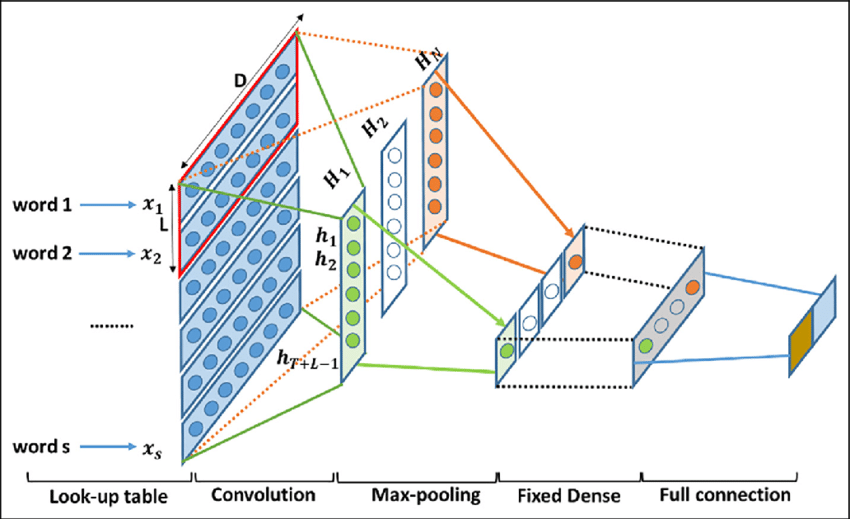

In [42]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(7, activation='softmax'))

# Add CRF layer----------------------------------
# model_cnn.add(CRF(5))
# model_cnn.compile(optimizer='adam', loss=crf_loss, metrics=[crf_viterbi_accuracy])
# -----------------------------------------------

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

y_pred_cnn = np.argmax(model_cnn.predict(X_test), axis=1)
accuracy_cnn = accuracy_score(y_test, y_pred_cnn) * 100

print(f"CNN Model Accuracy: {accuracy_cnn}%")

Epoch 1/10
22/22 [==============================] - 10s 406ms/step - loss: 1.8241 - accuracy: 0.3741 - val_loss: 1.6950 - val_accuracy: 0.3947
Epoch 2/10
22/22 [==============================] - 10s 436ms/step - loss: 1.7004 - accuracy: 0.3888 - val_loss: 1.6588 - val_accuracy: 0.3947
Epoch 3/10
22/22 [==============================] - 10s 437ms/step - loss: 1.5955 - accuracy: 0.3918 - val_loss: 1.6363 - val_accuracy: 0.3947
Epoch 4/10
22/22 [==============================] - 10s 438ms/step - loss: 1.4992 - accuracy: 0.4197 - val_loss: 1.6255 - val_accuracy: 0.3947
Epoch 5/10
22/22 [==============================] - 9s 419ms/step - loss: 1.2954 - accuracy: 0.4904 - val_loss: 1.6295 - val_accuracy: 0.3947
Epoch 6/10
22/22 [==============================] - 9s 425ms/step - loss: 1.0688 - accuracy: 0.6230 - val_loss: 1.6402 - val_accuracy: 0.3947
Epoch 7/10
22/22 [==============================] - 9s 428ms/step - loss: 0.8036 - accuracy: 0.7334 - val_loss: 1.6576 - val_accuracy: 0.4079
Ep

In [43]:
class_names = label_encoder.classes_
y_test_names = label_encoder.inverse_transform(y_test)
y_pred_names = label_encoder.inverse_transform(y_pred_cnn)

report = classification_report(y_test_names, y_pred_names, target_names=class_names)
print("CNN Model Classification Report:\n", report)

CNN Model Classification Report:
               precision    recall  f1-score   support

       anger       0.13      1.00      0.23        23
        fear       0.00      0.00      0.00         9
   happiness       0.00      0.00      0.00        43
        none       0.70      0.09      0.16        77
     sadness       0.00      0.00      0.00        14
    surprise       0.50      0.04      0.08        23

    accuracy                           0.16       189
   macro avg       0.22      0.19      0.08       189
weighted avg       0.36      0.16      0.10       189



c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

- Saving CNN model



In [44]:
# Saving the Bi-LSTM model
# model_lstm.save("Bi-LSTM_model.h5")

## Testing models
+ testing Bi-LSTM
+ testing CNN

In [45]:
def preprocess_text_for_prediction(text, tokenizer, max_length):
    cleaned_text = clean_text(text)
    translated_text = translate_to_arabic(cleaned_text)
    # Tokenize and pad the text
    text_sequence = tokenizer.texts_to_sequences([translated_text])
    text_padded = pad_sequences(text_sequence, maxlen=max_length)
    return text_padded

In [46]:
def predict_emotion(model, text_padded):
    predictions = model.predict(text_padded)
    return predictions[0]  # Return the probabilities for each class

In [47]:
new_text = "ana 3omry ma koft zay enhrdh"

new_text_padded = preprocess_text_for_prediction(new_text, tokenizer, X_padded.shape[1])
predicted_probabilities = predict_emotion(model_lstm, new_text_padded)

# Display the predicted emotion and probabilities
predicted_class = np.argmax(predicted_probabilities)
predicted_emotion = label_encoder.classes_[predicted_class]
probabilities_dict = {emotion: round(prob * 100, 2) for emotion, prob in zip(label_encoder.classes_, predicted_probabilities)}
sorted_probabilities = dict(sorted(probabilities_dict.items(), key=lambda item: item[1], reverse=True))

print(f"Predicted Emotion: {predicted_emotion}")
print("Probabilities:")
for emotion, prob in sorted_probabilities.items():
    print(f"{emotion}: {prob}%")

1/1 [==============================] - 0s 349ms/step
Predicted Emotion: happiness
Probabilities:
happiness: 93.59%
anger: 5.97%
none: 0.37%
surprise: 0.04%
sadness: 0.03%
fear: 0.0%


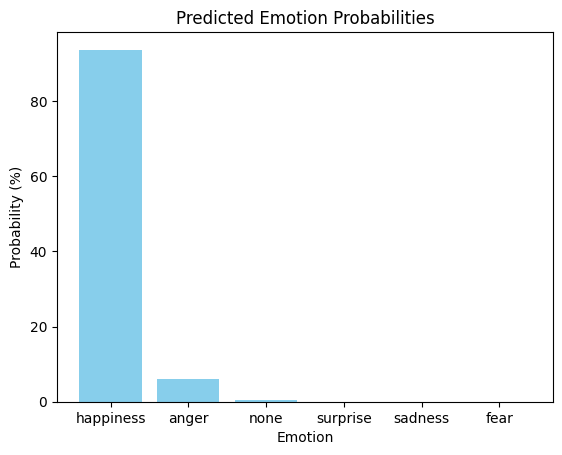

In [48]:
# Plotting the probabilities
plt.bar(sorted_probabilities.keys(), sorted_probabilities.values(), color='skyblue')
plt.title('Predicted Emotion Probabilities')
plt.xlabel('Emotion')
plt.ylabel('Probability (%)')
plt.show()